In [ ]:
import kagglehub

# Download latest version
data_path = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")

print("Path to dataset files:", data_path)

100%|██████████| 612M/612M [00:17<00:00, 37.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1


In [ ]:
#Importing Libraries
# Fundamental classes
import numpy as np
import pandas as pd
import tensorflow as tf
import os

#Preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight

# Image related
import cv2
from PIL import Image

# Performance Plot
from sklearn import metrics
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report, precision_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# For the model and it's training
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Time
import time
import datetime

#For testing
import random

In [ ]:
# Load the CSV files
meta_df = pd.read_csv('/root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1/Meta.csv')
train_df = pd.read_csv('/root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1/Train.csv')
test_df = pd.read_csv('/root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1/Test.csv')

print(meta_df.head())
print(train_df.head())
print(test_df.head())

          Path  ClassId  ShapeId  ColorId SignId
0  Meta/27.png       27        0        0   1.32
1   Meta/0.png        0        1        0   3.29
2   Meta/1.png        1        1        0   3.29
3  Meta/10.png       10        1        0   3.27
4  Meta/11.png       11        0        0   1.22
   Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId  \
0     27      26       5       5      22      20       20   
1     28      27       5       6      23      22       20   
2     29      26       6       5      24      21       20   
3     28      27       5       6      23      22       20   
4     28      26       5       5      23      21       20   

                             Path  
0  Train/20/00020_00000_00000.png  
1  Train/20/00020_00000_00001.png  
2  Train/20/00020_00000_00002.png  
3  Train/20/00020_00000_00003.png  
4  Train/20/00020_00000_00004.png  
   Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId            Path
0     53      54       6       5      48      49 

In [ ]:
#Preprocess images from a DataFrame
def load_and_preprocess_images(df, image_size=(30, 30)):
    images = []
    labels = []

    for index, row in df.iterrows():

        img_path = os.path.join(data_path, row['Path'])
        img = load_img(img_path, target_size=image_size)
        img_array = img_to_array(img)
        images.append(img_array)
        labels.append(row['ClassId'])

    return np.array(images), np.array(labels)

#Train Test Split
X_train, y_train = load_and_preprocess_images(train_df)
X_test, y_test = load_and_preprocess_images(test_df)
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0


In [ ]:
# Encode labels to one-hot vectors
num_classes = meta_df['ClassId'].nunique()
y_train_encoded = to_categorical(y_train, num_classes)
y_test_encoded = to_categorical(y_test, num_classes)

# Split data
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train_encoded,
    test_size=0.2,
    random_state=42
)

print("Training set shape:", X_train_split.shape)
print("Validation set shape:", X_val_split.shape)
print("Test set shape:", X_test.shape)


Training set shape: (31367, 30, 30, 3)
Validation set shape: (7842, 30, 30, 3)
Test set shape: (12630, 30, 30, 3)


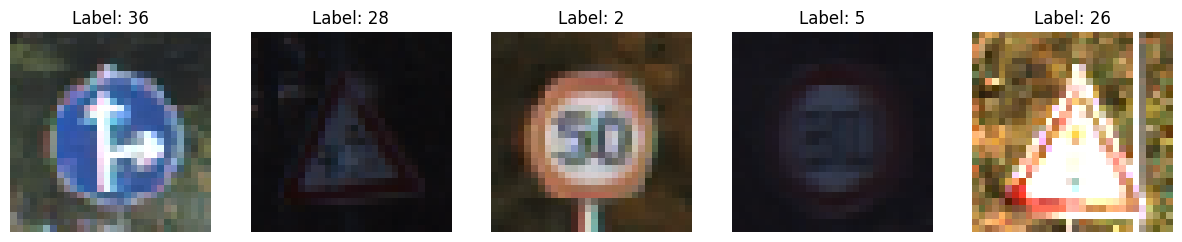

In [ ]:
#visulaize training images
def visualize_images(images, labels, num_images=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        plt.title(f"Label: {labels[i].argmax()}")
        plt.axis('off')
    plt.show()

visualize_images(X_train_split, y_train_split)

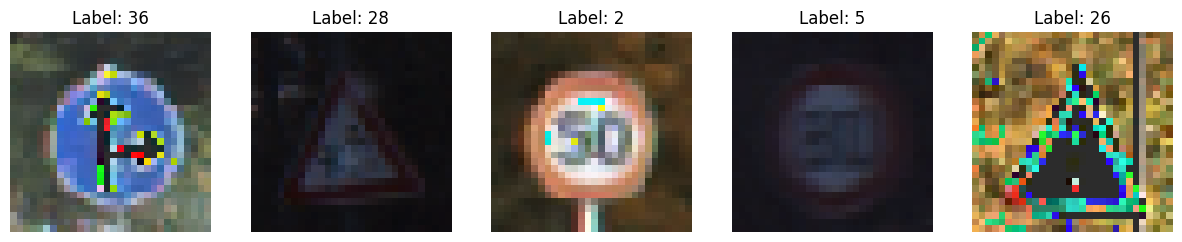

In [ ]:
import matplotlib.pyplot as plt

def visualize_images(images, labels, num_images=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        # Clip values to [0, 255] for display
        img_display = (images[i] * 300).astype(np.uint8)
        plt.imshow(img_display)
        plt.title(f"Label: {labels[i].argmax()}")
        plt.axis('off')
    plt.show()

visualize_images(X_train_split, y_train_split)

In [ ]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    fill_mode='nearest'
)

datagen.fit(X_train_split)


class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))

# Standardize dataset
mean = np.mean(X_train, axis=(0, 1, 2), keepdims=True)
std = np.std(X_train, axis=(0, 1, 2), keepdims=True)
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std


print("Class distribution in training data:")
print(pd.Series(y_train).value_counts())


Class distribution in training data:
2     2250
1     2220
13    2160
12    2100
38    2070
10    2010
4     1980
5     1860
25    1500
9     1470
7     1440
3     1410
8     1410
11    1320
18    1200
35    1200
17    1110
14     780
31     780
33     689
15     630
26     600
28     540
23     510
30     450
16     420
6      420
34     420
22     390
36     390
40     360
20     360
21     330
39     300
29     270
24     270
32     240
27     240
41     240
42     240
37     210
0      210
19     210
Name: count, dtype: int64


- end of preprocessing
- Bigenning of training

In [ ]:
#Function for Plotting Performance

def plot_performance(history = None, figure_directory = None, ylim_pad = [0, 0]):
    xlabel = 'Epoch'
    legends = ['Training', 'Validation']


    plt.figure(figsize = (20, 5))


    y1 = history.history['accuracy']
    y2 = history.history['val_accuracy']

    min_y = min(min(y1), min(y2)) - ylim_pad[0]
    max_y = max(max(y1), max(y2)) + ylim_pad[0]


    plt.subplot(121)

    plt.plot(y1)
    plt.plot(y2)

    plt.title('Model Accuracy\n', fontsize = 17)
    plt.xlabel(xlabel, fontsize = 15)
    plt.ylabel('Accuracy', fontsize = 15)
    plt.ylim(min_y, max_y)
    plt.legend(legends, loc = 'upper left')

    plt.grid()

    y1 = history.history['loss']
    y2 = history.history['val_loss']

    min_y = min(min(y1), min(y2)) - ylim_pad[1]
    max_y = max(max(y1), max(y2)) + ylim_pad[1]


    plt.subplot(122)

    plt.plot(y1)
    plt.plot(y2)

    plt.title('Model Loss\n', fontsize = 17)
    plt.xlabel(xlabel, fontsize = 15)
    plt.ylabel('Loss', fontsize = 15)
    plt.ylim(min_y, max_y)
    plt.legend(legends, loc = 'upper left')
    plt.grid()
    if figure_directory:
        plt.savefig(figure_directory + "/history")

    plt.show()

In [ ]:
#convolutional neural network (CNN)
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu', input_shape=X_train_split.shape[1:]))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.15))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.20))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(43, activation='softmax'))

# Compile model
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy', 'precision', 'f1_score']
)

# Displaying model architecture
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 22, 22, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 11, 11, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 11, 11, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 9, 9, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 7, 7, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 3, 3, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 3, 3, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 43)                  │          11,051 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,745,259 (6.66 MB)

 Trainable params: 1,745,259 (6.66 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Define early stopping
early_stopping = EarlyStopping(
    monitor='accuracy',
    min_delta=0.01,
    patience=2,
    restore_best_weights=True,
)


In [ ]:
# Training the model
with tf.device('/GPU:1'):
    epochs = 5
    history1 = model.fit(X_train_split, y_train_split, batch_size = 128, epochs = epochs, validation_data = (X_val_split, y_val_split))

Epoch 1/5
246/246 ━━━━━━━━━━━━━━━━━━━━ 280s 1s/step - accuracy: 0.3091 - f1_score: 0.2465 - loss: 2.5726 - precision: 0.6534 - val_accuracy: 0.9311 - val_f1_score: 0.9173 - val_loss: 0.2120 - val_precision: 0.9512
Epoch 2/5
246/246 ━━━━━━━━━━━━━━━━━━━━ 319s 1s/step - accuracy: 0.9223 - f1_score: 0.8965 - loss: 0.2566 - precision: 0.9460 - val_accuracy: 0.9487 - val_f1_score: 0.9388 - val_loss: 0.2549 - val_precision: 0.9838
Epoch 3/5
246/246 ━━━━━━━━━━━━━━━━━━━━ 323s 1s/step - accuracy: 0.9493 - f1_score: 0.9362 - loss: 0.1754 - precision: 0.9651 - val_accuracy: 0.9861 - val_f1_score: 0.9827 - val_loss: 0.0476 - val_precision: 0.9901
Epoch 4/5
246/246 ━━━━━━━━━━━━━━━━━━━━ 271s 1s/step - accuracy: 0.9767 - f1_score: 0.9711 - loss: 0.0733 - precision: 0.9815 - val_accuracy: 0.9893 - val_f1_score: 0.9874 - val_loss: 0.0401 - val_precision: 0.9913
Epoch 5/5
246/246 ━━━━━━━━━━━━━━━━━━━━ 271s 1s/step - accuracy: 0.9764 - f1_score: 0.9685 - loss: 0.0747 - precision: 0.9812 - val_accuracy: 0.9

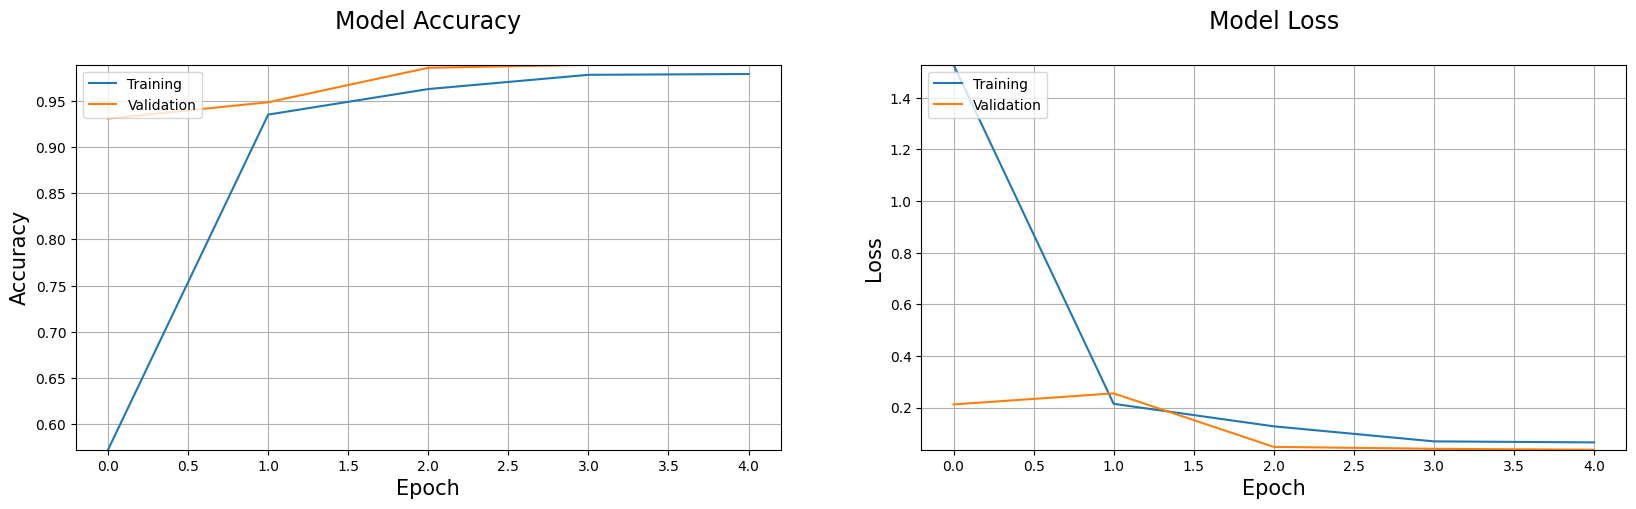

In [ ]:
#Visualize Training Performance
plot_performance(history = history1)

In [ ]:
# Importing the test dataset

labels = np.argmax(y_test_encoded, axis=1)

In [ ]:
# Set the TensorFlow device to GPU for model prediction
with tf.device('/GPU:0'):
    pred = np.argmax(model.predict(X_test), axis=-1)

# Calculate and display accuracy, precision, and F1 score for the test data
print("Accuracy Score:", accuracy_score(labels, pred))
print("Precision Score:", precision_score(labels, pred, average='macro'))
print("F1 Score:", f1_score(labels, pred, average='macro'))




395/395 ━━━━━━━━━━━━━━━━━━━━ 30s 75ms/step
Accuracy Score: 0.9545526524148852
Precision Score: 0.9308073047921714
F1 Score: 0.9251182038352888



Confusion Matrix

[[ 60   0   0 ...   0   0   0]
 [  3 704   5 ...   0   0   0]
 [  0   8 739 ...   0   0   0]
 ...
 [  0   0   0 ...  79   0   0]
 [  0   0   0 ...   0  38   0]
 [  0   0   0 ...   0  20  70]] 



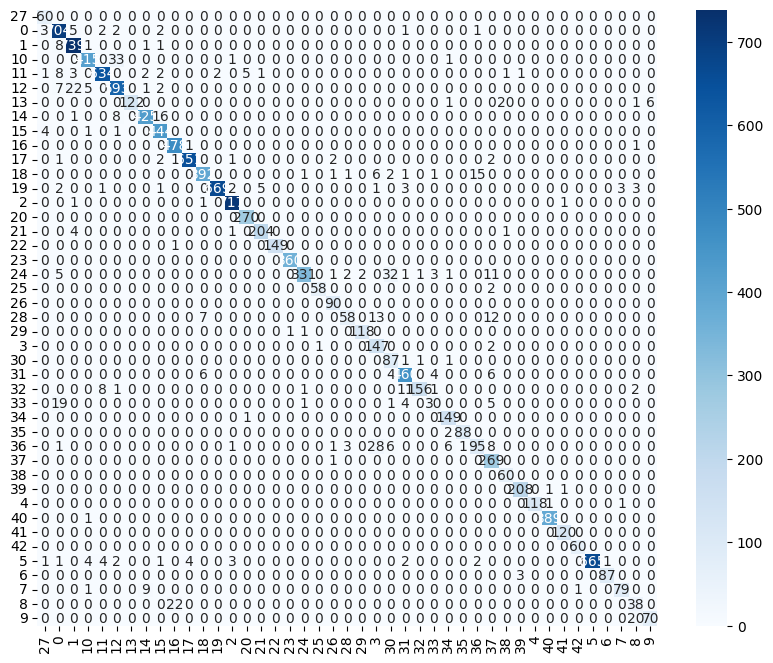

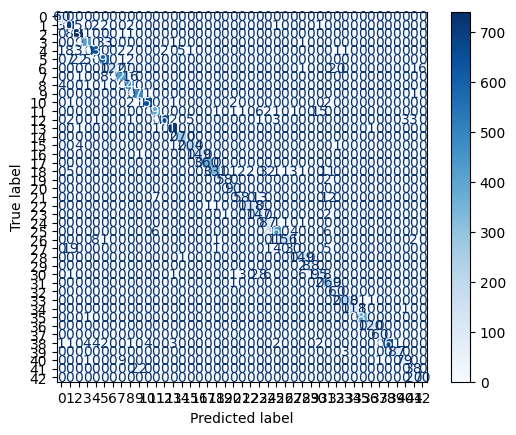

Classification Report

              precision    recall  f1-score   support

           0       0.87      1.00      0.93        60
           1       0.93      0.98      0.95       720
           2       0.95      0.99      0.97       750
           3       0.97      0.92      0.95       450
           4       0.98      0.96      0.97       660
           5       0.93      0.94      0.93       630
           6       1.00      0.81      0.90       150
           7       0.97      0.94      0.96       450
           8       0.94      0.99      0.96       450
           9       0.95      1.00      0.97       480
          10       0.99      0.99      0.99       660
          11       0.97      0.93      0.95       420
          12       1.00      0.97      0.98       690
          13       0.99      1.00      0.99       720
          14       0.98      1.00      0.99       270
          15       0.97      0.97      0.97       210
          16       1.00      0.99      1.00       150
    

In [ ]:
#Confusion Matrix
print("\nConfusion Matrix\n")
confMatrix = confusion_matrix(labels, pred)
print(confMatrix, "\n")

# Extract the unique class labels from both true and predicted labels
all_labels = np.unique(np.concatenate([labels, pred]))

#Figure for the confusion matrix heatmap
plt.figure(figsize=(10, 8))
dis = ConfusionMatrixDisplay(confusion_matrix=confMatrix, display_labels=[str(i) for i in all_labels])
sns.heatmap(confMatrix, annot=True, fmt='d', cmap='Blues', xticklabels=meta_df['ClassId'], yticklabels=meta_df['ClassId'])
dis.plot(cmap=plt.cm.Blues)
plt.show()

# Generate classification report
print("Classification Report\n")
print(classification_report(labels, pred))


Testing On Set Images: 
 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


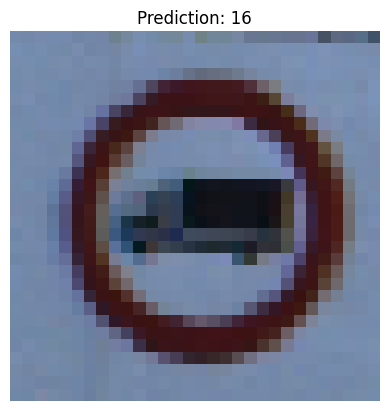

Prediction for 16: Veh > 3.5 tons prohibited
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


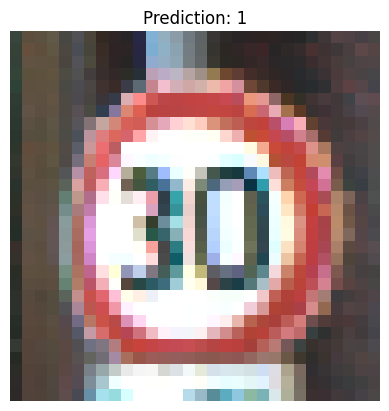

Prediction for 1: Speed limit (30km/h)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


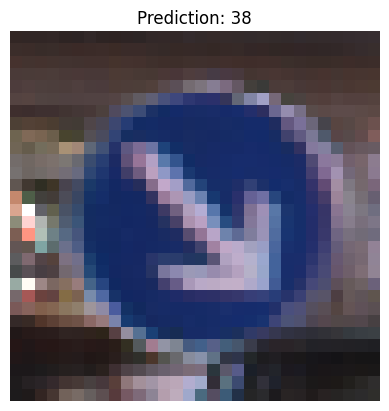

Prediction for 38: Keep right
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


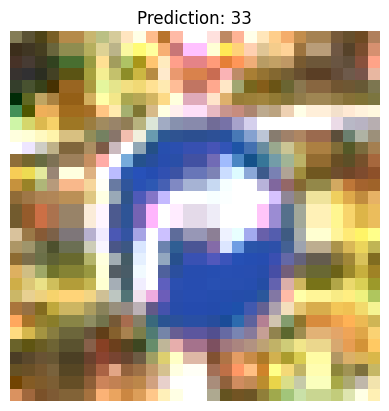

Prediction for 33: Turn right ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


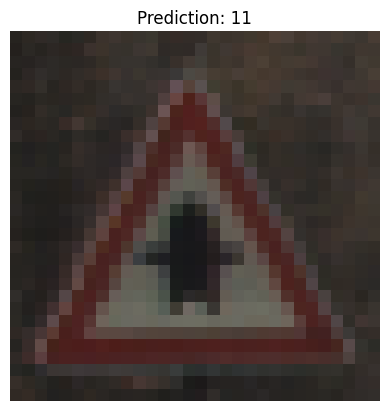

Prediction for 11: Right-of-way at intersection
Testing On Random Images: 
 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


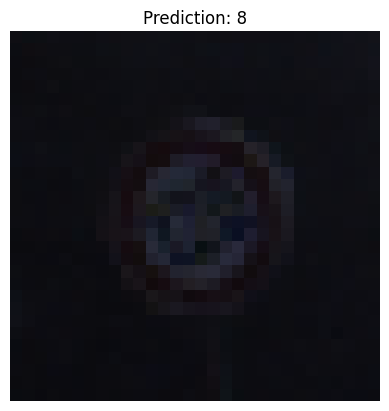

Prediction for 8: Speed limit (120km/h)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


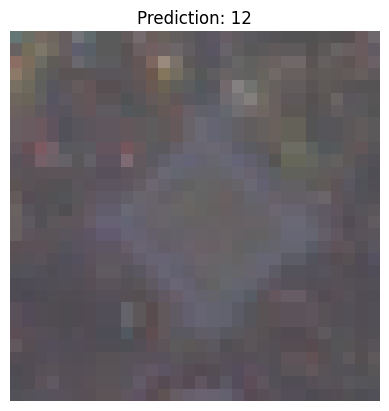

Prediction for 12: Priority road
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


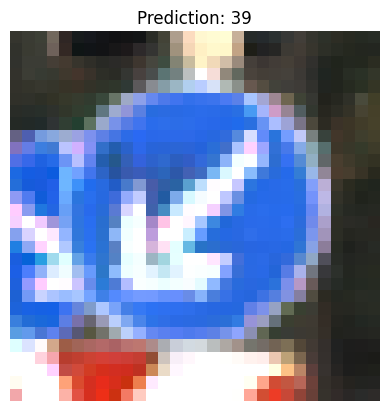

Prediction for 39: Keep left
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


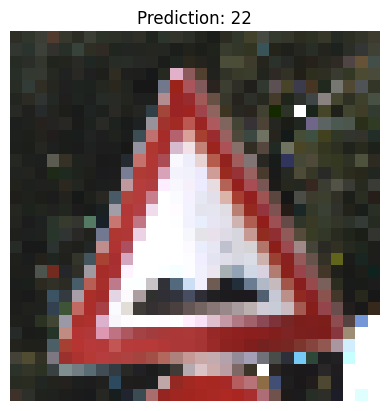

Prediction for 22: Bumpy road
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


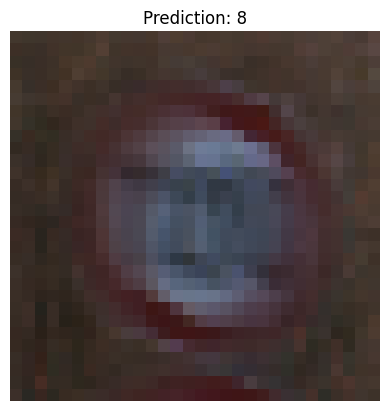

Prediction for 8: Speed limit (120km/h)


In [ ]:
#Testing

class_label ={ 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)',
            2:'Speed limit (50km/h)',
            3:'Speed limit (60km/h)',
            4:'Speed limit (70km/h)',
            5:'Speed limit (80km/h)',
            6:'End of speed limit (80km/h)',
            7:'Speed limit (100km/h)',
            8:'Speed limit (120km/h)',
            9:'No passing',
            10:'No passing veh over 3.5 tons',
            11:'Right-of-way at intersection',
            12:'Priority road',
            13:'Yield',
            14:'Stop',
            15:'No vehicles',
            16:'Veh > 3.5 tons prohibited',
            17:'No entry',
            18:'General caution',
            19:'Dangerous curve left',
            20:'Dangerous curve right',
            21:'Double curve',
            22:'Bumpy road',
            23:'Slippery road',
            24:'Road narrows on the right',
            25:'Road work',
            26:'Traffic signals',
            27:'Pedestrians',
            28:'Children crossing',
            29:'Bicycles crossing',
            30:'Beware of ice/snow',
            31:'Wild animals crossing',
            32:'End speed + passing limits',
            33:'Turn right ahead',
            34:'Turn left ahead',
            35:'Ahead only',
            36:'Go straight or right',
            37:'Go straight or left',
            38:'Keep right',
            39:'Keep left',
            40:'Roundabout mandatory',
            41:'End of no passing',
            42:'End no passing veh > 3.5 tons' }

print("Testing On Set Images: \n \n")
# Loop through each image in the folder
for i in range(5):
  #for lb, im in zip(labels, X_test):
      im = X_test[i]
      lb = labels[i]

      # Load and preprocess the image
      test_image = np.expand_dims(im, axis=0)

      # Normalize and make prediction
      result = model.predict(test_image)

      # Get the predicted class index
      prediction_index = np.argmax(result)

      # Display the image
      plt.imshow(im)
      plt.axis('off')
      plt.title(f"Prediction: {prediction_index}")
      plt.show()

      print(f"Prediction for {lb}:\033[1m {class_label[int(prediction_index)]}\033[0m")
      print("===========================================================")

print("Testing On Random Images: \n \n")
for i in range(5):
  random_index = random.randint(1, len(X_test))
  random_image = X_test[random_index]
  random_label = labels[random_index]

  # Load and preprocess the image
  test_image = np.expand_dims(random_image, axis=0)

  # Normalize and make prediction
  result = model.predict(test_image)

  # Get the predicted class index
  prediction_index = np.argmax(result)

  # Display the image
  plt.imshow(random_image)
  plt.axis('off')
  plt.title(f"Prediction: {prediction_index}")
  plt.show()

  print(f"Prediction for {random_label}:\033[1m {class_label[int(prediction_index)]}\033[0m")
  print("===========================================================")